# 'Step by step' simple tutorial towards binary image classification 

with Pytorch

#### 1. Define the default directory path 

In [338]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [339]:
%cd /content/drive/MyDrive/딥러닝기초

/content/drive/MyDrive/딥러닝기초


#### 2. Import basic Pytorch libraries. There will be more libraries coming up later.

In [340]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

#### 3. Define the path to the directory where images are located 

In [341]:
data_dir = './smile_binary_image_classification'

#### 4. You can check directories located in the main project directory. Here we will call them 'classes'.

In [342]:
import os 

'''
- what is os library?
The OS module in Python provides functions 
for creating and removing a directory (folder), 
fetching its contents, changing and identifying the current directory, etc. 
'''

classes = os.listdir(data_dir)
classes

['smile', 'test', 'non_smile']

> We have our training images - faces with/out smile in subdirectories restructively. 


> We can also see that we have a seperate directory for test images.

#### 5. Visualize sample images

> It is helpful to see some random images to understand our dataset.

Train images with smiling faces :)
Number of images in the directory 600


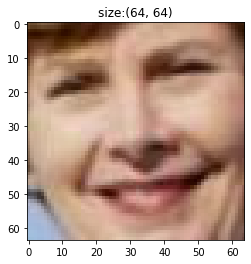

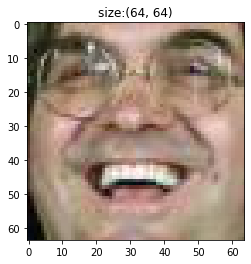



These are sample test images:
Number of images in the directory 12030


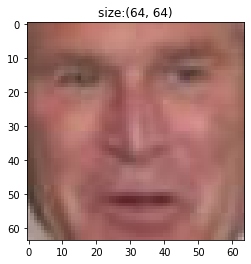

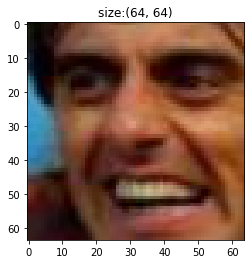



Train images with not smiling faces :(
Number of images in the directory 603


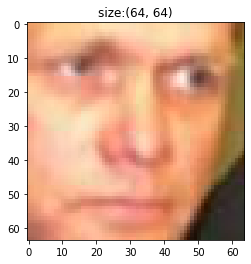

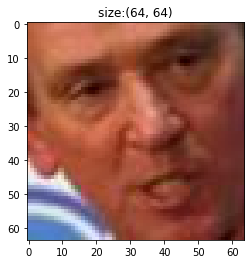

In [343]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
from glob import glob

for cl in classes:
  if cl == 'test':
    print('These are sample test images:')
  elif cl == 'smile':
    print('Train images with smiling faces :)')
  else:
    print('Train images with not smiling faces :(')

  # Define image path to a 'cl' directory
  image_path = data_dir + '/' + cl + '/'

  ''' 
  - What is glob library?
  The glob module is a useful part of the Python standard library. 
  glob (short for global) is used to return all file paths that match a specific pattern.
  '''

  # We use * to fetch up all images in the corresponding directory without checking matching patterns
  image_paths = glob(os.path.join(image_path,  '*'))
  print('Number of images in the directory',len(image_paths))

  # For each directory we will visualize only two images, just to have a glimpse of our data
  # We will use _ like below, because we will get random index using random.randint()
  for _ in range(2):
    idx = np.random.randint(0, len(image_paths))
    image = Image.open(image_paths[idx])

    #Visualize our sample image with plt.imshow()
    plt.imshow(image)
    #Show the image size as well 
    plt.title(f'size:{image.size}')
    plt.show() 
  
  print('\n')

> It seems that all images have the same image size which is (64,64). And it has colors, RGB image! 

> Thus, the common image size is : (64,64,3)


The image size is really small but for our binary classification task, it will not be so problematic.

#### 6. Image transformation 

In order to use image data for our future pytorch model, we need to tranform the images into tensors. 

6.1 Define how you want to transform images with **torchvision.transforms**.

6.2 Apply the same transformation to every images in the directories easily with **ImageFolder**.

In [344]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.ToTensor()])

In [345]:
dataset = ImageFolder(data_dir, transform = transformations)

#### 7. Split dataset

Since we have 3 subdirectories, which are smile, non_smile and test, we need to split the smile and non_smile images into training and validation data.

Here, we leave out the test directory and define a new subset for all images in the first two subdirectories.

In [346]:
from torch.utils.data import Subset

# select images that are not in the 'test' directory, which is positioned in the index number 2 in the main directory.
idx = [i for i in range(len(dataset)) if dataset.imgs[i][1] != dataset.class_to_idx['test']]
# build the appropriate subset
subset = Subset(dataset, idx)

In [347]:
len(subset)

1203

> Now it is time to split the subset! Let's define the ratio, respectively.

In [348]:
train_ratio = int(len(subset)*0.8)
val_ratio = int(len(subset)*0.2)+1

In [349]:
train_ratio+val_ratio

1203

In [350]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(subset, [train_ratio,val_ratio])
len(train_ds), len(val_ds)

(962, 241)

We have 962 training images mixed of smiling and not smiling faces. 241 images for validation.

Each datapoint is a made of tensor that defines the image and a class integer. Check out the first datapoint in the training dataset.

In [351]:
train_ds[0]

(tensor([[[0.6588, 0.6510, 0.6471,  ..., 0.5451, 0.5373, 0.4824],
          [0.6588, 0.6549, 0.6510,  ..., 0.5647, 0.5490, 0.4902],
          [0.6588, 0.6588, 0.6588,  ..., 0.5843, 0.5608, 0.4941],
          ...,
          [0.3882, 0.4824, 0.5333,  ..., 0.2824, 0.2588, 0.2588],
          [0.4235, 0.4863, 0.5294,  ..., 0.2706, 0.2510, 0.2510],
          [0.4431, 0.4627, 0.5137,  ..., 0.2627, 0.2431, 0.2431]],
 
         [[0.5098, 0.5020, 0.4980,  ..., 0.4549, 0.4471, 0.3961],
          [0.5098, 0.5059, 0.5020,  ..., 0.4745, 0.4627, 0.4039],
          [0.5176, 0.5176, 0.5176,  ..., 0.4941, 0.4745, 0.4078],
          ...,
          [0.2980, 0.3922, 0.4314,  ..., 0.2471, 0.2588, 0.2706],
          [0.3216, 0.3765, 0.4196,  ..., 0.2431, 0.2510, 0.2627],
          [0.3333, 0.3451, 0.3961,  ..., 0.2353, 0.2392, 0.2549]],
 
         [[0.4275, 0.4196, 0.4157,  ..., 0.3922, 0.3922, 0.3412],
          [0.4275, 0.4235, 0.4196,  ..., 0.4118, 0.4078, 0.3490],
          [0.4314, 0.4314, 0.4314,  ...,

We can check the proportion of classes in the training and validation dataset! 

In [352]:
'''from collections import Counter

train_values = [item[1] for item in train_ds]
Counter(train_values)'''

'from collections import Counter\n\ntrain_values = [item[1] for item in train_ds]\nCounter(train_values)'

In [353]:
from collections import Counter

val_values = [item[1] for item in val_ds]
Counter(val_values)

Counter({0: 117, 1: 124})

#### 8. Data augmentation

The number of images for training the model is much smaller compared to the test dataset. In this case, we can augement our images to increase training performance and avoid possible overfitting problem. 

In [354]:
from torch.utils.data import Dataset

class ApplyTransform(Dataset):
    """
    Apply transformations to a Dataset

    Arguments:
        dataset (Dataset): A Dataset that returns (sample, target)
        transform (callable, optional): A function/transform to be applied on the sample
        target_transform (callable, optional): A function/transform to be applied on the target

    """
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

In [355]:
data_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.5, contrast=0.3 ),
        transforms.RandomGrayscale(),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomAdjustSharpness(0.5)])

In [356]:
train_ds = ApplyTransform(train_ds, transform=data_transforms)
val_ds = ApplyTransform(val_ds, transform=data_transforms)
     

We will load our data and apply our augmentation process defined above. 

Moreover, the data will be loaded as batches, each with a size of 32 images.

In [357]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [358]:
train_loader = DataLoader(train_ds,
                            batch_size,
                            num_workers = 4,
                            shuffle=True)
val_loader = DataLoader(val_ds,
                         batch_size,
                         num_workers = 4,
                        shuffle=True)

Nothing is blackbox until training the DL model. We can visualize a sample batch with images.

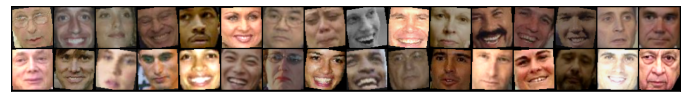

In [359]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break
        
show_batch(val_loader)     

####9. Train model

In [360]:
device = 'cuda'

In [361]:
def train(model, trainLoader):
    model.to(device)
    model.train()
    train_loss = 0
    train_acc = 0
    for image, label in trainLoader:
        image, label = image.to(device), label.to(device)
        output = model(image)
        loss = loss_fn(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    train_loss /= len(trainLoader)
    train_acc /= len(trainLoader.dataset)
    return train_loss, train_acc


def test(model, testLoader):
    test_loss = 0
    test_acc = 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for image, label in testLoader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            test_loss += loss.item()
            test_acc += (torch.argmax(output, dim=1) == label).sum().item()
        
    test_loss /= len(testLoader)
    test_acc /= len(testLoader.dataset)
    return test_loss, test_acc

We will use a pretrained model GoogLeNet.

In [362]:
# Use pretrained GoogLeNet
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet = googlenet.to(device)

In [363]:
# To check summary of model
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [364]:
summary(googlenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [365]:
'''ct = 0
for child in googlenet.children():
  ct += 1
  if ct <  8 :
    for param in child.parameters():
      param.requires_grad = False
    print('freeze!!!')'''

"ct = 0\nfor child in googlenet.children():\n  ct += 1\n  if ct <  8 :\n    for param in child.parameters():\n      param.requires_grad = False\n    print('freeze!!!')"

Since we are dealing with binary classification the last fully connected layer must have 2 neurons - classes. 

In [366]:
googlenet.fc = nn.Linear(1024, 2, device=device)

We will define our loss function as well as optimizer.

In [367]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(googlenet.parameters(), lr=1e-3)

Let our training process begin! 

In [368]:
N_EPOCH = 10

for epoch in range(1, N_EPOCH+1):
    print(f'EPOCH {epoch}')
    loss, accuracy = train(googlenet, train_loader )
    val_loss, val_accuracy = test(googlenet, val_loader)
    
    print('     Train | Loss : {:7.4f}, Accuracy : {:6.2f} %'.format(
        loss, accuracy*100))
    print('Validation | Loss : {:7.4f}, Accuracy : {:6.2f} %\n'.format(
        val_loss, val_accuracy*100))

EPOCH 1
     Train | Loss :  0.4279, Accuracy :  84.51 %
Validation | Loss :  0.1703, Accuracy :  95.02 %

EPOCH 2
     Train | Loss :  0.1655, Accuracy :  94.39 %
Validation | Loss :  0.1066, Accuracy :  97.10 %

EPOCH 3
     Train | Loss :  0.1793, Accuracy :  95.95 %
Validation | Loss :  0.0919, Accuracy :  96.68 %

EPOCH 4
     Train | Loss :  0.1177, Accuracy :  95.74 %
Validation | Loss :  0.0725, Accuracy :  97.93 %

EPOCH 5
     Train | Loss :  0.1240, Accuracy :  96.15 %
Validation | Loss :  0.0812, Accuracy :  96.68 %

EPOCH 6
     Train | Loss :  0.1151, Accuracy :  95.95 %
Validation | Loss :  0.0876, Accuracy :  97.10 %

EPOCH 7
     Train | Loss :  0.0938, Accuracy :  96.67 %
Validation | Loss :  0.0594, Accuracy :  98.34 %

EPOCH 8
     Train | Loss :  0.0771, Accuracy :  97.40 %
Validation | Loss :  0.0605, Accuracy :  98.76 %

EPOCH 9
     Train | Loss :  0.1620, Accuracy :  96.57 %
Validation | Loss :  0.0679, Accuracy :  97.93 %

EPOCH 10
     Train | Loss :  0.0593,

#### 10. Test model

Unfortunately our test images have no labels. Thus, we cannot use the test dataset to test our model. 

For now, we will use the validation image data to visualize the prediction result of our model.

In [369]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]
     

Let's also check out images that are predicted wrong!

Label: non_smile , Predicted: smile


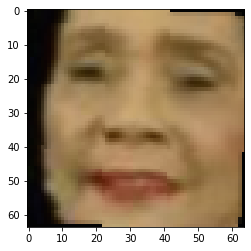

Label: smile , Predicted: non_smile


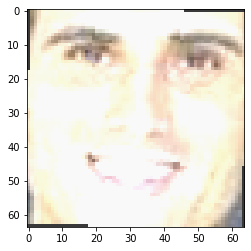

Label: smile , Predicted: non_smile


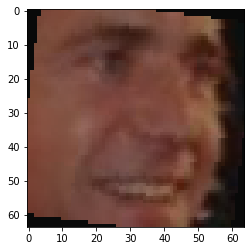

Model was able to classify 238 images correctly!
Model was wrong 3 times.


In [370]:
True_cnt = 0
False_cnt = 0

for i in range(len(val_ds)):
  img, label = val_ds[i]
  predicted_label = predict_image(img, googlenet)
  original_label = dataset.classes[label]
  if original_label == predicted_label:
    True_cnt += 1
  else:
    False_cnt += 1
    print('Label:', original_label, ', Predicted:', predicted_label)
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

print(f'Model was able to classify {True_cnt} images correctly!')
print(f'Model was wrong {False_cnt} times.')